In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the dataset using the user's provided parsing logic
path = "stud_per.csv"
with open(path, 'r', encoding='utf-8') as f:
    header_line = f.readline().strip()
    columns = header_line.split(';')
    rows = []
    for line in f:
        s = line.strip()
        if not s:
            continue
        # remove outer quotes if present
        if s.startswith('"') and s.endswith('"'):
            s = s[1:-1]
        # replace double double-quotes with a single quote char
        s = s.replace('""', '"')
        parts = s.split(';')
        parts = [p.strip().strip('"') for p in parts]
        if len(parts) < len(columns):
            parts += [None] * (len(columns) - len(parts))
        elif len(parts) > len(columns):
            parts = parts[:len(columns)]
        rows.append(parts)

df = pd.DataFrame(rows, columns=columns)

# Convert relevant columns to numeric types.
numeric_cols_to_convert = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures',
                           'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health',
                           'absences', 'G1', 'G2', 'G3']

for col in numeric_cols_to_convert:
    # Coerce errors to handle any non-numeric values
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Initial inspection of the dataset
print("Parsed shape:", df.shape)
print("Columns:", df.columns.tolist())
print("\nData Info:")
df.info()
print("\nFirst 5 rows:")
display(df.head())

Parsed shape: (395, 33)
Columns: ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 1

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


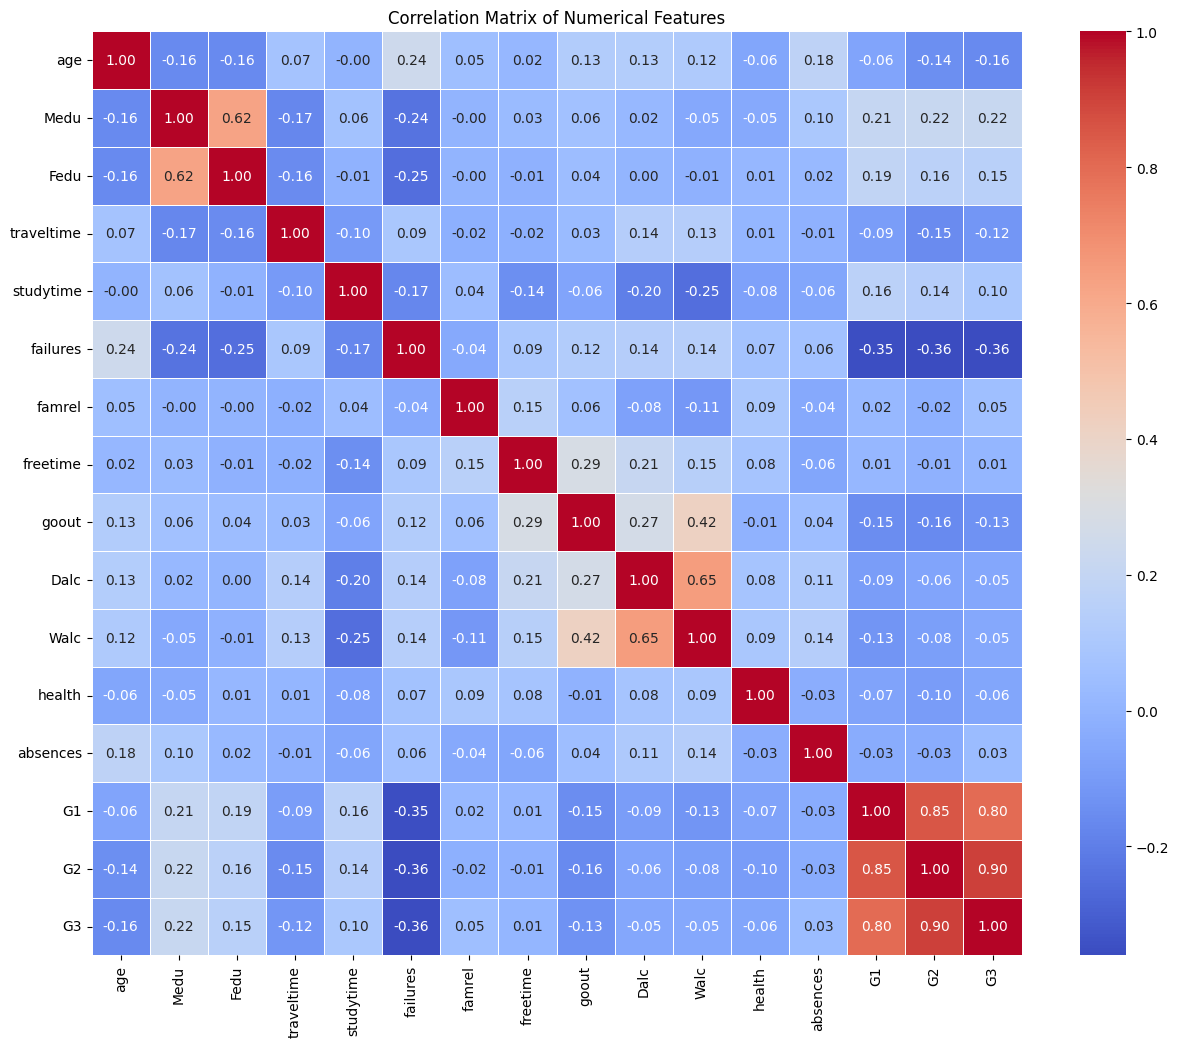


Correlation of features with G3:
G3            1.000000
G2            0.904868
G1            0.801468
Medu          0.217147
Fedu          0.152457
studytime     0.097820
famrel        0.051363
absences      0.034247
freetime      0.011307
Walc         -0.051939
Dalc         -0.054660
health       -0.061335
traveltime   -0.117142
goout        -0.132791
age          -0.161579
failures     -0.360415
Name: G3, dtype: float64


In [8]:
# Select only numeric columns for correlation analysis
numeric_df = df.select_dtypes(include=np.number)

# Calculate the correlation matrix
correlation_matrix = numeric_df.corr()

# Visualize the correlation matrix with a heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Numerical Features')
plt.savefig('correlation_matrix.png')
plt.show()

# Print the correlations with G3
print("\nCorrelation of features with G3:")
print(correlation_matrix['G3'].sort_values(ascending=False))

# Prepare data for modeling
# Drop rows with NaN values if any (though our info() check showed none)
df_clean = df.dropna()
X = df_clean.drop('G3', axis=1)
y = df_clean['G3']

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Simple Linear Regression using 'G1'
# Select the feature for simple linear regression
X_simple_train = X_train[['G1']]
X_simple_test = X_test[['G1']]

# Create and train the model
simple_lr_model = LinearRegression()
simple_lr_model.fit(X_simple_train, y_train)

# Make predictions
y_pred_simple_lr = simple_lr_model.predict(X_simple_test)

# Evaluate the model
r2_simple_lr = r2_score(y_test, y_pred_simple_lr)
mse_simple_lr = mean_squared_error(y_test, y_pred_simple_lr)
mae_simple_lr = mean_absolute_error(y_test, y_pred_simple_lr)

print("Simple Linear Regression (G1):")
print(f"R-squared: {r2_simple_lr:.4f}")
print(f"Mean Squared Error (MSE): {mse_simple_lr:.4f}")
print(f"Mean Absolute Error (MAE): {mae_simple_lr:.4f}")

Simple Linear Regression (G1):
R-squared: 0.6995
Mean Squared Error (MSE): 6.1627
Mean Absolute Error (MAE): 1.8553


In [10]:
# Multiple Linear Regression with selected features
features_multi_lr = ['G1', 'G2', 'studytime', 'failures']

# Create a preprocessing and model pipeline
multi_lr_pipeline = Pipeline(steps=[
    ('preprocessor', StandardScaler()),
    ('regressor', LinearRegression())
])

# Train the model
multi_lr_pipeline.fit(X_train[features_multi_lr], y_train)

# Make predictions
y_pred_multi_lr = multi_lr_pipeline.predict(X_test[features_multi_lr])

# Evaluate the model
r2_multi_lr = r2_score(y_test, y_pred_multi_lr)
mse_multi_lr = mean_squared_error(y_test, y_pred_multi_lr)
mae_multi_lr = mean_absolute_error(y_test, y_pred_multi_lr)

print("Multiple Linear Regression (G1, G2, studytime, failures):")
print(f"R-squared: {r2_multi_lr:.4f}")
print(f"Mean Squared Error (MSE): {mse_multi_lr:.4f}")
print(f"Mean Absolute Error (MAE): {mae_multi_lr:.4f}")

Multiple Linear Regression (G1, G2, studytime, failures):
R-squared: 0.7817
Mean Squared Error (MSE): 4.4761
Mean Absolute Error (MAE): 1.2916


In [11]:
# SGDRegressor with the same features
features_sgd = ['G1', 'G2', 'studytime', 'failures']

# Create a preprocessing and model pipeline for SGD
sgd_pipeline = Pipeline(steps=[
    ('preprocessor', StandardScaler()),
    ('regressor', SGDRegressor(random_state=42, max_iter=1000, tol=1e-3))
])

# Train the model
sgd_pipeline.fit(X_train[features_sgd], y_train)

# Make predictions
y_pred_sgd = sgd_pipeline.predict(X_test[features_sgd])

# Evaluate the model
r2_sgd = r2_score(y_test, y_pred_sgd)
mse_sgd = mean_squared_error(y_test, y_pred_sgd)
mae_sgd = mean_absolute_error(y_test, y_pred_sgd)

print("SGDRegressor (G1, G2, studytime, failures):")
print(f"R-squared: {r2_sgd:.4f}")
print(f"Mean Squared Error (MSE): {mse_sgd:.4f}")
print(f"Mean Absolute Error (MAE): {mae_sgd:.4f}")

SGDRegressor (G1, G2, studytime, failures):
R-squared: 0.7821
Mean Squared Error (MSE): 4.4681
Mean Absolute Error (MAE): 1.3049


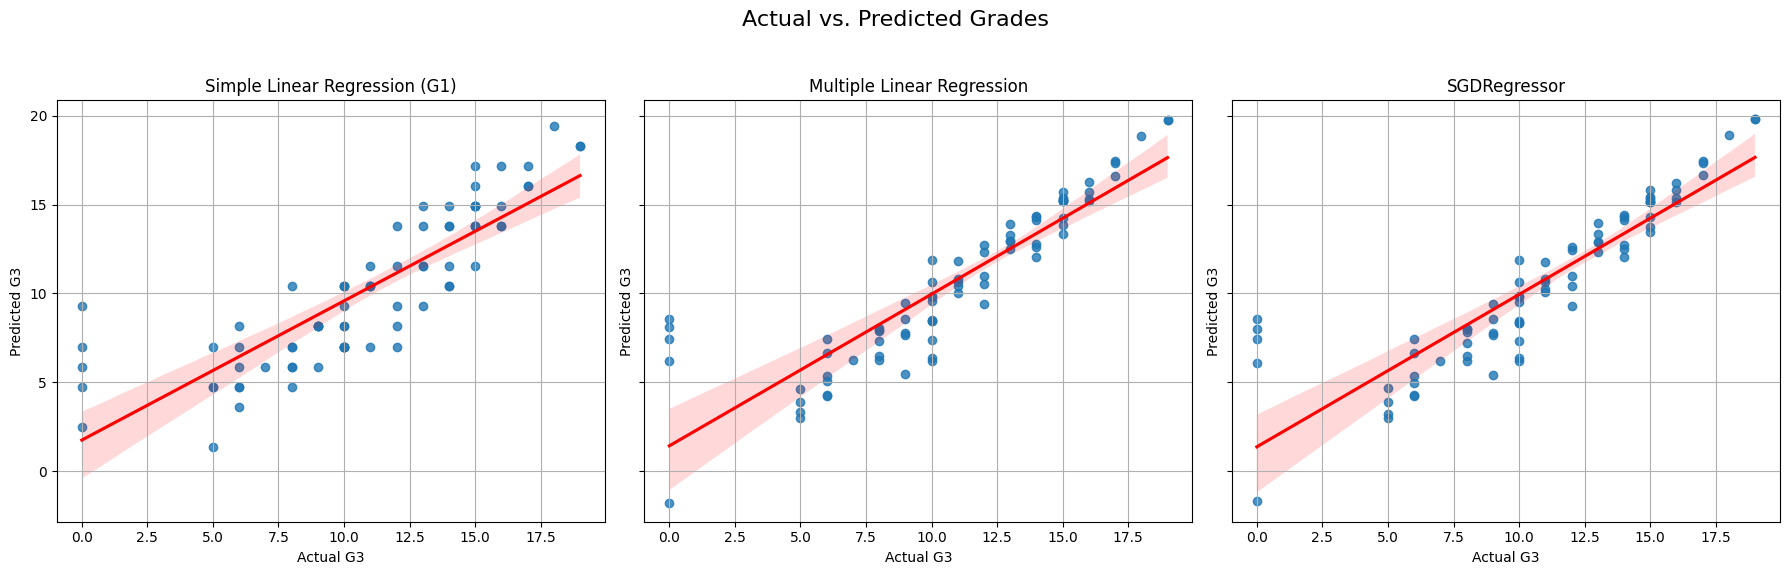

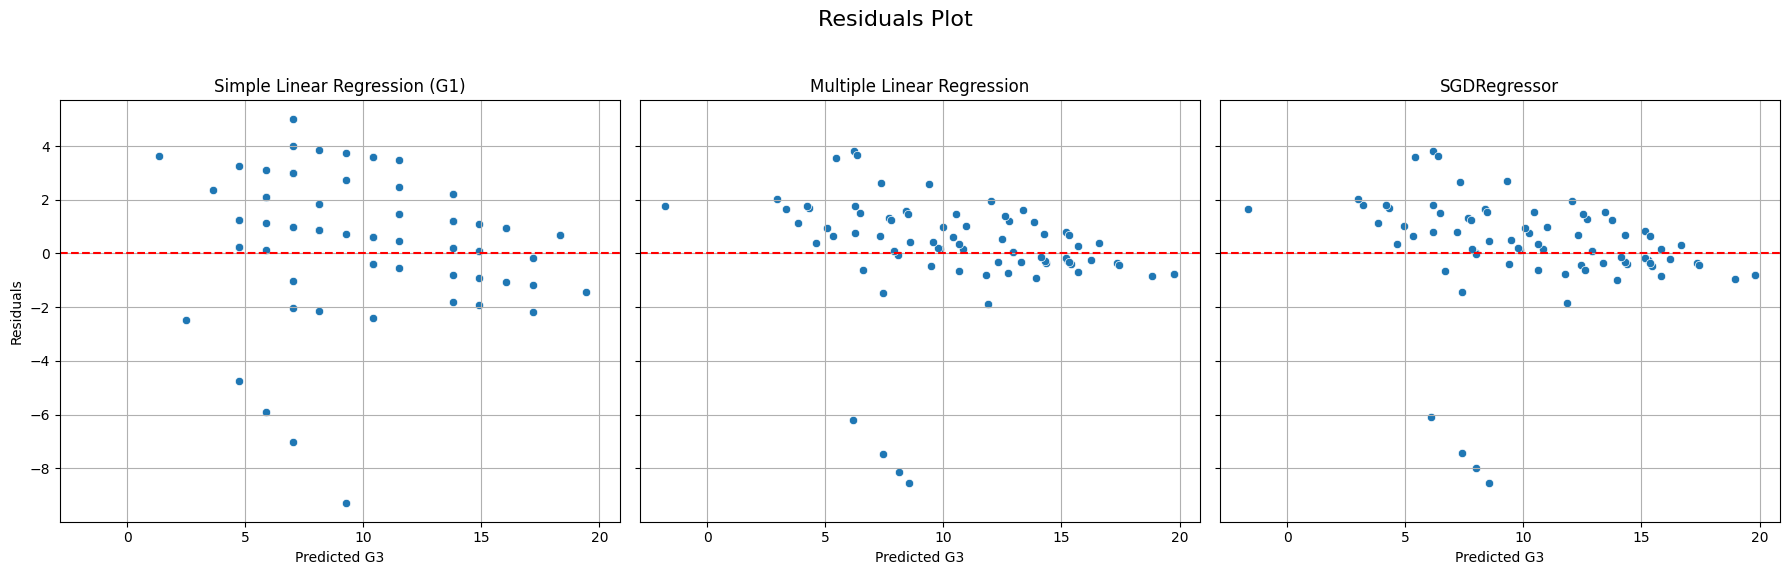

In [12]:
# Plot Actual vs. Predicted Grades
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)
fig.suptitle('Actual vs. Predicted Grades', fontsize=16)

# Simple Linear Regression Plot
sns.regplot(x=y_test, y=y_pred_simple_lr, ax=axes[0], line_kws={"color": "red"})
axes[0].set_title('Simple Linear Regression (G1)')
axes[0].set_xlabel('Actual G3')
axes[0].set_ylabel('Predicted G3')
axes[0].grid(True)

# Multiple Linear Regression Plot
sns.regplot(x=y_test, y=y_pred_multi_lr, ax=axes[1], line_kws={"color": "red"})
axes[1].set_title('Multiple Linear Regression')
axes[1].set_xlabel('Actual G3')
axes[1].set_ylabel('Predicted G3')
axes[1].grid(True)

# SGDRegressor Plot
sns.regplot(x=y_test, y=y_pred_sgd, ax=axes[2], line_kws={"color": "red"})
axes[2].set_title('SGDRegressor')
axes[2].set_xlabel('Actual G3')
axes[2].set_ylabel('Predicted G3')
axes[2].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('actual_vs_predicted.png')
plt.show()

# Calculate residuals
residuals_simple_lr = y_test - y_pred_simple_lr
residuals_multi_lr = y_test - y_pred_multi_lr
residuals_sgd = y_test - y_pred_sgd

# Plot Residuals
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)
fig.suptitle('Residuals Plot', fontsize=16)

# Simple Linear Regression Residuals
sns.scatterplot(x=y_pred_simple_lr, y=residuals_simple_lr, ax=axes[0])
axes[0].axhline(y=0, color='r', linestyle='--')
axes[0].set_title('Simple Linear Regression (G1)')
axes[0].set_xlabel('Predicted G3')
axes[0].set_ylabel('Residuals')
axes[0].grid(True)

# Multiple Linear Regression Residuals
sns.scatterplot(x=y_pred_multi_lr, y=residuals_multi_lr, ax=axes[1])
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].set_title('Multiple Linear Regression')
axes[1].set_xlabel('Predicted G3')
axes[1].set_ylabel('Residuals')
axes[1].grid(True)

# SGDRegressor Residuals
sns.scatterplot(x=y_pred_sgd, y=residuals_sgd, ax=axes[2])
axes[2].axhline(y=0, color='r', linestyle='--')
axes[2].set_title('SGDRegressor')
axes[2].set_xlabel('Predicted G3')
axes[2].set_ylabel('Residuals')
axes[2].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('residuals.png')
plt.show()